# Data handling and processing

**Installing and importing dependencies**

In [1]:
!pip install torchinfo

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms as T
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
from torchinfo import summary
from skimage import io

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm import tqdm
import cv2

import os

**Preparing data**

In [3]:
image_dirs=['/kaggle/input/wikiart-art-movementsstyles/Renaissance/Renaissance',
           '/kaggle/input/wikiart-art-movementsstyles/Romanticism/Romanticism']
dir2img = {d: i for i, d in enumerate(image_dirs)}
dir2img = {d: i for i, d in dir2img.items()}

print(dir2img)

{0: '/kaggle/input/wikiart-art-movementsstyles/Renaissance/Renaissance', 1: '/kaggle/input/wikiart-art-movementsstyles/Romanticism/Romanticism'}


In [4]:
class LoadImgData():
    """ Load data from each dir as np arr and save loaded dataset."""
    def __init__(self):
        self.ren = image_dirs[0]
        self.rom = image_dirs[1]
        self.labels = {self.ren: np.eye(2, 2)[0], self.rom: np.eye(2, 2)[1]}
        self.dataset = []
        self.ren_count = 0
        self.rom_count = 0

    def create_dataset(self):
        """Read image paths from dir and save them with labels."""
        for key in self.labels:
          print(key)
          for img_file in tqdm(os.listdir(key)):
            try:
              path = os.path.join(key, img_file)
              
              self.dataset.append([path, self.labels[key]])
              
              if key == self.ren:
                self.ren_count+=1
              elif key == self.rom:
                self.rom_count+=1

            except Exception as e:
              pass
     
#         np.random.shuffle(self.dataset)
    
        print(f'\n renaissance art images: {self.ren_count}')
        print(f' romanticism art images: {self.rom_count}')
        print(f'total: {self.ren_count + self.rom_count}')
        return np.array(self.dataset, dtype='object')
    
    #save path,label

In [5]:
img_data = LoadImgData()
dataset = img_data.create_dataset()

/kaggle/input/wikiart-art-movementsstyles/Renaissance/Renaissance


100%|██████████| 6192/6192 [00:00<00:00, 301327.67it/s]


/kaggle/input/wikiart-art-movementsstyles/Romanticism/Romanticism


100%|██████████| 6813/6813 [00:00<00:00, 290557.95it/s]


 renaissance art images: 6192
 romanticism art images: 6813
total: 13005


In [6]:
class ArtDataset(Dataset):
    def __init__(self, custom_dataset, transform=None):
        
        self.custom_dataset = custom_dataset
        self.transform= transform

    def __len__(self):
        return len(self.custom_dataset)
    
    def __getitem__(self, idx):
        image_path = self.custom_dataset[idx][0]
        image = cv2.imread(image_path)
        label = torch.tensor(self.custom_dataset[idx][1])
        if self.transform:
          image = self.transform(image)
        return (image, label)
    #take loadimgdata samples dataset arr, index idx row, you get path, label. read 
    

In [7]:
mean, std=(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
img_size=224
data_transforms=T.Compose([T.ToTensor(), T.Resize((img_size, img_size)), T.Normalize(mean, std)])


In [8]:
dataset = ArtDataset(dataset, transform=data_transforms)

In [9]:
train_set_size = int(len(dataset) * 0.75)
valid_set_size = len(dataset) - train_set_size
train_set, valid_set = data.random_split(dataset, [train_set_size, valid_set_size])

In [10]:
train_dataloader = DataLoader(train_set, shuffle=True, batch_size=32)
valid_dataloader = DataLoader(valid_set, shuffle=True, batch_size=32)

**Plotting out image.** 

In [11]:
def denorm(tensor, mean=0.5, std=0.5):
    output=std*tensor+mean
    return torch.clamp(output, 0,1)

In [12]:
image_batch, label_batch=next(iter(train_dataloader))
image, label = image_batch[0] , label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor([1., 0.], dtype=torch.float64))

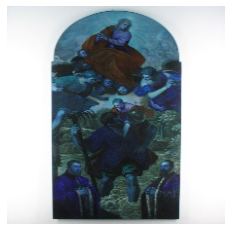

In [13]:
plt.imshow(denorm(image.permute(1, 2, 0)))
plt.axis(False);

------------------------------------

# Model utilities

**Patch Embedding**

In [14]:
class PatchEmbedding(nn.Module):
    
    '''
    Takes a 2-D image and turns it into a 1D sequence learnable embedding.
    
    Args:
        in_channels(int): number of color channels (C) default:3
        patch_size(int): side of sq patch
        embedding_dim: output dim  (N x (P^2 . C))
    ''' 
    
    def __init__(self, in_channels:int=3, 
                 patch_size:int=16,
                embedding_dim:int=768):
        super().__init__()
        
        #conv layer to turn images into patches
        self.patcher=nn.Conv2d(in_channels=in_channels,
                               out_channels=embedding_dim,
                               kernel_size=patch_size,
                               stride=patch_size,
                               padding=0)
        
        #flatten layer to flatten patch feature maps into a single dimension
        self.flatten=nn.Flatten(start_dim=2,
                               end_dim=3)
        
    def forward(self, x):
        img_resolution=x.shape[-1]
#         assert img_resolution % patch_size==0, f"Input img size should be divisible by patch size for proper patching execution."
        
        x_patched=self.patcher(x)
        x_flattened=self.flatten(x_patched)
        
        return x_flattened.permute(0, 2, 1)

In [15]:
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [16]:

random_input_image = (1, 3, 224, 224)

summary(PatchEmbedding(), 
        input_size=random_input_image,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

**Class Token Embedding**